In [2]:
from ase.io import read
import matplotlib.pyplot as plt
import numpy as np

import abtem

# Contrast Transfer Function
The [Contrast Transfer Function](https://en.wikipedia.org/wiki/Contrast_transfer_function) (CTF) describes the aberrations of the objective lens in HRTEM and specifies how the condenser system shapes the probe in STEM. Here we describe how to create a CTF with specific aberrations and how this affects the resulting images.

## Polar expansion of the phase error (aberrations)
Ideally, a lens forms a spherical wave converging on or emerging from a single point. In practice, aberrations cause the wave front to deviate from a spherical surface. This deviation can be represented as a phase error, $\chi(k, \phi)$, of the spatial frequency in polar coordinates. The phase error can be written as a series expansion

$$ 
    \chi(\alpha, \phi) = \frac{2 \pi}{\lambda} \sum_{n,m} \frac{1}{n + 1} C_{n,m} (k \lambda)^{n+1} \cos\left[m (\phi - \phi_{n,m}) \right] \quad ,
$$

where $n,m$ index the different aberrations.

If the microscope is well aligned then off-axis aberrations (astigmatisms) are small and the phase error is dominated by the first two isotropic terms

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f = -C_{1,1}$ is the defocus and $C_s=C_{3,3}$ is the third order spherical aberration.

The `CTF` object takes parameters of the form `Cnm` and `phinm`, and may also be given using their common aliases, e.g. `defocus = -C10` **(Note the negative sign in this definition)**. The expansion is implemented up to 5th order, and all the coefficients labels are shown in the table below.

`abTEM` exclusively uses polar expansion coefficients; however, a conversion utility from the Cartesian to the polar representation is available in `abtem.waves.transfer.cartesian2polar`.

## Phase aberrations
We create a `CTF` for an electron energy of $300 \ \mathrm{keV}$, a spherical aberration of $-7~\mu \mathrm{m}$ (remember that abTEM uses units of Å) and the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy) (here $-45.5 \ \mathrm{Å}$).

In [159]:
Cs = -10e-6 * 1e10

ctf = abtem.CTF(Cs=Cs, energy=300e3)
ctf.defocus = ctf.scherzer_defocus

print(f"defocus = {ctf.defocus:.2f} Å")

defocus = -54.34 Å


This can also be accomplished by setting the parameters with a dictionary.

In [160]:
aberrations = {'C10': -ctf.defocus, 'C30': Cs}

ctf = abtem.CTF(aberrations=aberrations, energy=ctf.energy)

We can use the method `.show` to preview the CTF along a radial direction up to a given angle (in milliradians).

<AxesSubplot:xlabel='scattering angle [mrad]'>

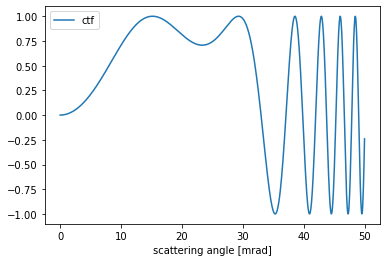

In [161]:
ctf.profiles().show(units='mrad')

Given the exit wave function $\phi_{exit}$ and the phase error $\chi$, the wave function at the image plane is given by

$$  
    \phi_{image}(\alpha, \phi) = \phi_{exit}(\alpha, \phi) \exp(-i \chi(\alpha, \phi)) \quad .
$$


To perform this operation, we use the `apply_ctf` method. Here we apply the CTF to the exit wave from an earlier tutorial.

[########################################] | 100% Completed |  0.3s


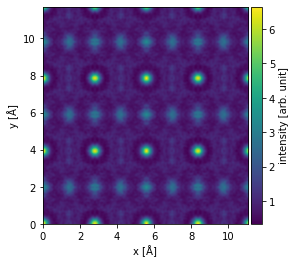

In [162]:
exit_wave = abtem.PlaneWave(energy=300e3, sampling=.05).multislice(read('data/srtio3_110.cif'))

image_wave = exit_wave.apply_ctf(ctf)

image_wave.show(cbar=True);

## Aperture and partial coherence (quasi-coherent approximation)

The maximum transferred frequency is limited by the aperture of the objective lens. This is conventionally described as a multiplication with the aperture function and in the qausi-coherent approximation a partial coherence envelope. Hence, the wave function at the image plane becomes

$$
    \phi_{\mathrm{image}}(\alpha, \phi) = \phi_{\mathrm{exit}}(\alpha, \phi) E_t(k) E_s(k) A(k) \exp[-i \chi(\alpha, \phi)] \quad .
$$

Wherea $A(k)$ is the aperture function

$$
    A(k) = \begin{cases} 1 & \text{if } x \geq k_{cut} \\ 0 & \text{if } x < k_{cut} \end{cases} .
$$

and $E_t(k)$ and $E_s(k)$, to be defined below are the temporal and spatial envelopes, respectively. 

We will cut off the `CTF` at the angle corresponding to the Scherzer [point resolution](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus), which is defined as the angle (in radians) where the CTF crosses the abscissa for the first time.

In [165]:
ctf.semiangle_cutoff = ctf.crossover_angle

print(f"semiangle cutoff: {ctf.crossover_angle:.2f} mrad")

semiangle cutoff: 32.97 mrad


[########################################] | 100% Completed |  0.2s


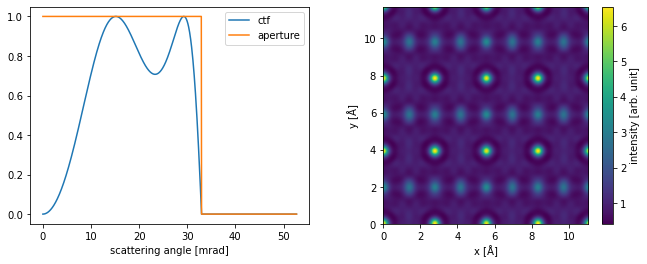

In [166]:
image_wave = exit_wave.apply_ctf(ctf)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 4))

ctf.profiles().show(ax=ax1, units='mrad')

image_wave.show(ax=ax2, cbar=True);

### Temporal coherence
Partial coherence acts similarly to the aperture function to dampen the high spatial frequencies of the signal. The most important source of partial coherence in HRTEM is partial temporal coherence.

A small spread in energy, $\Delta E$, of the incident electrons is due to the chromatic aberration of the objective lens equivalent to a small spread in defocus. Fluctuations in the focusing currents, $\Delta I$, of the objective lens also produce an incoherent spread in defocus. Combining these effects, the $1 / e$ width (here $e \approx 2.71828$ denotes the Euler number) of the distribution of defocus values (the focal spread) can be written as

$$
    \delta = C_c \sqrt{4 \left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2}.
$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source. $C_c$ is the chromatic aberration coefficient. Assuming $\delta$ is small, it can be shown that the focal spread can be approximated as

$$
    E_t(k) = \exp\left[-\frac{1}{4} \left(\pi \lambda \delta \right)^2 k^4 \right] .
$$

The parameter $\delta$ above is equivalent to the `focal_spread` argument of the `CTF`.

### Partial spatial coherence
As the electron source has a finite size, the incident beam contains a distribution of incident directions. In HRTEM this is quantified by the angular spread. Assuming that each incident direction performs its own scattering and that the distribution of incident directions is small, then it can be shown that the angular spread can be modelled by the spatial coherence envelope function, as given by

$$
    E_s(k) = \exp\left(-\frac{\beta}{4\lambda^2}\left| \frac{\partial \chi(k)}{\partial k}\right|^2  \right) .
$$

where $\beta$ is the $1/e$ width of the distribution of angles. The parameter $\beta$ is equivalent to `angular_spread`.

### Deflections and thermal magnetic field noise
Blurring can also be caused by all kinds of noise leading to a random deflection of the image relative to the detector, such as vibrations, drift of the stage, and magnetic noise fields resulting from eddy currents in the material of the lenses. Assuming that the image deflection is small and follows a Gaussian distribution, this can be included as an additional envelope

[########################################] | 100% Completed |  0.2s


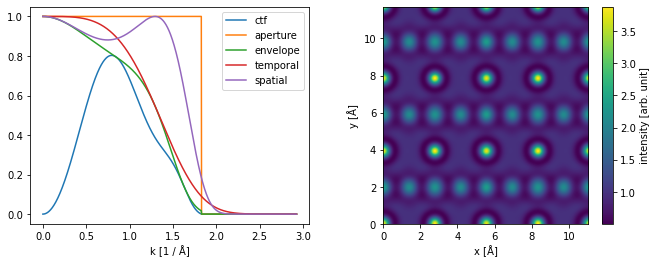

In [110]:
ctf.focal_spread = 15
ctf.angular_spread = 5

image_wave = exit_wave.apply_ctf(ctf).intensity()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

ctf.profiles().show(ax=ax1)

image_wave.show(ax=ax2, cbar=True);

## The contrast transfer functions in 2D

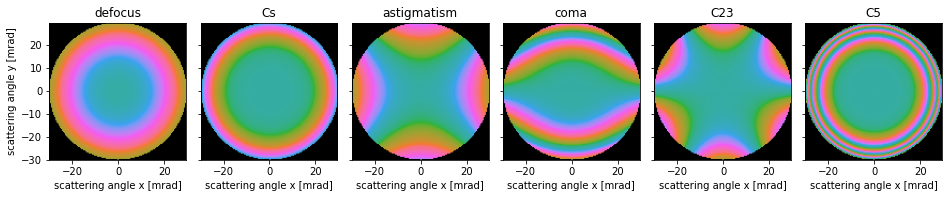

In [141]:
aberrations = [{'defocus': 60}, {'Cs':1.6e5}, {'astigmatism':60}, {'coma':7e3}, {'C23':3e3}, {'C5':1e9}]

ctfs = [abtem.CTF(energy=100e3, semiangle_cutoff=30, aberrations=aberration) for aberration in aberrations]

ctf_images = [ctf.image(gpts=(128,128), max_angle=30) for ctf in ctfs]

ctf_images = abtem.stack(ctf_images, axis_metadata=[list(aberration.keys())[0] for aberration in aberrations])

ctf_images.show(explode=True, 
                figsize=(16,6), 
                image_grid_kwargs = {'axes_pad': .2}, 
                units='mrad');


Looking at equation 

[########################################] | 100% Completed |  0.1s


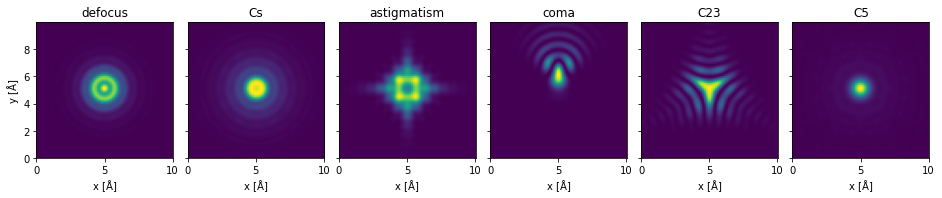

In [142]:
probes = [abtem.Probe(energy=100e3, semiangle_cutoff=30, aberrations=aberration, gpts=exit_wave.gpts, extent=30) for aberration in aberrations]

probe_images = [probe.build().intensity() for probe in probes]

probe_images = abtem.stack(probe_images, axis_metadata=[list(aberration.keys())[0] for aberration in aberrations])

probe_images = probe_images.crop(extent=(10,10), offset=(10,10))

probe_images.show(explode=True, 
                  figsize=(16,6), 
                  image_grid_kwargs = {'axes_pad': .2}
                  );

We can further model the effect of different types of aberrations on our probe by changing the parameters of the contrast transfer function.

## Focal series

In [ ]:


ctf = abtem.CTF(defocus=defocus)







$$
    E_d(k) = \exp\left(- \frac{\sigma^2 k^2}{2}\right) ,
$$

where $\sigma$ is the $1/e$ width of the deflection. The parameter $\sigma$ is equivalent to the `gaussian_spread`.